## Co-citation Network Clustering and Analysis

In [47]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import community as community_louvain # python-louvain library
import community.community_louvain as community_louvain # python-louvain library
from collections import Counter, defaultdict 
import re
from pathlib import Path
import numpy as np
import json # For handling API responses
import time # For potential delays between API calls
import asyncio # For running async functions
import requests

# For text processing, if you want more advanced tokenization (optional)
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.util import ngrams



### Configuration

In [48]:
# --- Configuration ---
GRAPHML_FILE_PATH = "data/graphml/smartcity_2.graphml"
NUMBER_OF_TOP_CLUSTERS_TO_SHOW = 10
NUMBER_OF_TOP_PAPERS_PER_CLUSTER = 5 # Reduced for brevity in the new table
NUMBER_OF_TOP_KEYWORDS_PER_CLUSTER = 10 # For Uni-grams
NUMBER_OF_TOP_BIGRAMS_PER_CLUSTER = 5
NUMBER_OF_TOP_AUTHORS_PER_CLUSTER = 5
MIN_CLUSTER_SIZE_FOR_ANALYSIS = 5 # Minimum number of nodes for a cluster to be analyzed




In [ ]:
import os 
from dotenv import load_dotenv

load_dotenv()

API_KEY = os.getenv("GEMINI_API_KEY", "")
LLM_MODEL_NAME = "gemini-2.0-flash"

In [42]:
# Define stopwords (customize as needed)
STOPWORDS = set([
    "the", "a", "an", "is", "are", "was", "were", "of", "and", "to", "in", "it", "that", "this",
    "for", "on", "with", "as", "by", "at", "from", "about", "into", "onto", "through", "over",
    "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how",
    "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor",
    "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just",
    "don", "should", "now", "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "couldn",
    "didn", "doesn", "hadn", "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "shan",
    "shouldn", "wasn", "weren", "won", "wouldn", "fig", "figure", "table", "abstract", "introduction",
    "results", "discussion", "conclusion", "references", "et", "al", "paper", "study", "method",
    "analysis", "based", "using", "system", "approach", "model", "data", "research",
    "urban", "computing", "city", "cities", "science", "review", "survey", "p", "pp", "vol", "v",
    "issue", "journal", "conference", "workshop", "chapter", "university", "department", "dept",
    "institute", "ieee", "acm", "elsevier", "springer", "wiley", "press", "proc", "int", "j", "ann",
    "soc", "sci", "technol", "res", "commun", "comput", "syst", "eur", "lect", "notes", "adv", 
    "ser", "trans", "eng", "manag", "appl", "rev", "lett", "rep", "bull", "mem", "assoc", "symp",
    "inc", "ltd", "corp", "org", "co", "ed", "eds", "vol", "no", "pp", "chap", "art", "isbn",
    "doi", "http", "https", "www", "com", "org", "net", "pdf", "html", "gov", "edu",
    # Common author initials/short names (can be expanded)
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z",
    "dr", "prof", "phd", "ms", "mr", "mrs", "inc", "corp", "ltd"
])

### 1. Load Co-citation Graph

In [6]:
graph_path = Path(GRAPHML_FILE_PATH)
if not graph_path.exists():
    print(f"ERROR: GraphML file not found at {graph_path}")
    print("Please ensure 'build_network.py' has been run and the file path is correct.")
    G = None
else:
    G = nx.read_graphml(graph_path)
    print(f"Graph loaded from {graph_path}")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

# Ensure node attributes are of correct type (freq should be int, year str/int)
if G is not None:
    for node, data in G.nodes(data=True):
        if 'freq' in data:
            try:
                data['freq'] = int(data['freq'])
            except (ValueError, TypeError):
                data['freq'] = 0 # Default if conversion fails
        else:
            data['freq'] = 0
        
        if 'year' in data:
            data['year'] = str(data['year']) # Keep as string for now, convert to int when needed
        else:
            data['year'] = 'Unknown'

Graph loaded from data\graphml\smartcity_2.graphml
Number of nodes: 18807
Number of edges: 456645


### 2. Graph Preprocessing (Largest Connected Component)

In [7]:
if G is not None and G.number_of_nodes() > 0:
    # Convert to undirected graph for Louvain if it's directed
    if G.is_directed():
        G_undirected = G.to_undirected()
        print("Converted graph to undirected for community detection.")
    else:
        G_undirected = G
    
    # Find the largest connected component (LCC)
    # Community detection algorithms often work best on connected graphs.
    connected_components = list(nx.connected_components(G_undirected))
    if connected_components:
        largest_component_nodes = max(connected_components, key=len)
        G_lcc = G_undirected.subgraph(largest_component_nodes).copy()
        print(f"Largest Connected Component (LCC) selected for analysis:")
        print(f"  Nodes in LCC: {G_lcc.number_of_nodes()}")
        print(f"  Edges in LCC: {G_lcc.number_of_edges()}")
    else:
        print("Graph has no connected components (it might be empty or all isolated nodes).")
        G_lcc = G_undirected # Fallback to original graph if no components
else:
    G_lcc = None
    print("Graph is not loaded or is empty. Skipping further analysis.")

Largest Connected Component (LCC) selected for analysis:
  Nodes in LCC: 18520
  Edges in LCC: 456622


### 3. Community Detection (Louvain Algorithm)

In [ ]:
partition = {} # Initialize partition dictionary
num_communities = 0 # Initialize number of communities
modularity = 0.0 # Initialize modularity

if G_lcc is not None and G_lcc.number_of_nodes() > 0:
    if G_lcc.number_of_edges() > 0: # Check if there are edges to form communities
        print("Performing community detection using Louvain algorithm...")
        # Compute the best partition using Louvain algorithm, considering edge weights
        partition = community_louvain.best_partition(G_lcc, weight='weight', random_state=42)
        
        # Add community information to node attributes in G_lcc
        nx.set_node_attributes(G_lcc, partition, 'community')
        
        num_communities = len(set(partition.values()))
        print(f"Number of communities found: {num_communities}")
        
        if num_communities > 0:
            # Modularity calculation requires edges
            modularity = community_louvain.modularity(partition, G_lcc, weight='weight')
            print(f"Modularity of the partition: {modularity:.4f}")
        else:
            # This case should be rare if partition is non-empty, but good for robustness
            print("No communities were effectively formed (num_communities is 0).")
    else:
        print("Skipping community detection: The largest connected component has no edges.")
        # Nodes will not have 'community' attribute set if this path is taken
        # Ensure downstream code handles nodes without 'community' or an empty partition dict
else:
    print("Skipping community detection as graph (LCC) is not suitable (None or no nodes).")



Performing community detection using Louvain algorithm...
Number of communities found: 21
Modularity of the partition: 0.5099


### 4. Helper Functions for Cluster Analysis

In [28]:
def simple_tokenizer(text):
    """A very basic tokenizer that splits by non-alphanumeric and converts to lower.
       It also tries to handle hyphenated words and common journal patterns.
    """
    if not isinstance(text, str):
        return []
    # Preserve hyphens within words, remove leading/trailing hyphens after split
    text = re.sub(r'([a-zA-Z])-|-(?=[a-zA-Z])', r'\1', text.lower())
    words = re.split(r'[^a-z0-9-]+', text)
    return [word.strip('-') for word in words if word.strip('-') and len(word.strip('-')) > 1] # Min length 2

def extract_keywords_from_node_attributes(nodes_data_list, stopwords_set, top_n=10):
    """Extracts keywords from 'source' and 'author' attributes of nodes in a cluster."""
    all_words = []
    for node_data in nodes_data_list:
        # Extract text from source (journal/conference name)
        source_text = node_data.get('source', '')
        if isinstance(source_text, str):
            words = simple_tokenizer(source_text)
            all_words.extend([w for w in words if w not in stopwords_set and not w.isdigit()])
        
        # Optionally, extract from author names (might be less topical)
        # author_text = node_data.get('author', '')
        # if isinstance(author_text, str):
        #     words = simple_tokenizer(author_text)
        #     all_words.extend([w for w in words if w not in stopwords_set and not w.isdigit()])
            
    if not all_words:
        return []
    
    word_counts = Counter(all_words)
    return [word for word, count in word_counts.most_common(top_n)]

def get_cluster_details(graph, partition_map, min_size_for_analysis, num_top_papers, num_top_keywords, stopwords_set):
    """Analyzes each cluster to find top papers and keywords."""
    cluster_summaries = []
    if not partition_map:
        return pd.DataFrame()

    # Group nodes by community ID
    communities = defaultdict(list)
    for node, comm_id in partition_map.items():
        communities[comm_id].append(node)

    # Sort communities by size (number of nodes)
    sorted_communities = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)

    print(f"\nAnalyzing top communities (min size: {min_size_for_analysis})...")
    for comm_id, nodes_in_comm in sorted_communities:
        if len(nodes_in_comm) < min_size_for_analysis:
            continue
        
        # Get data for nodes in this community
        nodes_data_in_comm = [graph.nodes[node] for node in nodes_in_comm if node in graph.nodes]
        
        # Sort nodes by 'freq' (overall citation count of the cited reference) descending
        # The 'label' attribute is the "AUTHOR, YEAR, SOURCE" string
        sorted_nodes_by_freq = sorted(nodes_data_in_comm, key=lambda x: x.get('freq', 0), reverse=True)
        
        top_papers_info = []
        for node_data in sorted_nodes_by_freq[:num_top_papers]:
            label = node_data.get('label', 'Unknown Label')
            freq = node_data.get('freq', 0)
            year = node_data.get('year', 'Unknown')
            top_papers_info.append(f"{label} (Freq: {freq}, Year: {year})")
            
        # Extract keywords from all nodes in the community
        keywords = extract_keywords_from_node_attributes(nodes_data_in_comm, stopwords_set, num_top_keywords)
        
        # Calculate average year and year range for the cluster (cited reference years)
        years_in_comm = [int(data['year']) for data in nodes_data_in_comm if data['year'].isdigit()]
        avg_year = np.mean(years_in_comm) if years_in_comm else 'N/A'
        min_year = min(years_in_comm) if years_in_comm else 'N/A'
        max_year = max(years_in_comm) if years_in_comm else 'N/A'
        year_range_str = f"{min_year}-{max_year}" if min_year != 'N/A' else 'N/A'
        
        cluster_summaries.append({
            'Cluster ID': comm_id,
            'Size (Nodes)': len(nodes_in_comm),
            'Avg. Cited Year': f"{avg_year:.1f}" if isinstance(avg_year, float) else avg_year,
            'Cited Year Range': year_range_str,
            f'Top {num_top_papers} Cited Refs': "; ".join(top_papers_info),
            f'Top {num_top_keywords} Keywords': ", ".join(keywords)
        })
        
    return pd.DataFrame(cluster_summaries)

In [34]:
# def advanced_tokenizer(text, stopwords_set):
#     """Tokenizes text, converts to lower, removes stopwords and short tokens."""
#     if not isinstance(text, str):
#         return []
#     tokens = word_tokenize(text.lower())
#     return [token for token in tokens if token.isalpha() and token not in stopwords_set and len(token) > 2]

# def extract_top_unigrams(nodes_data_list, stopwords_set, top_n=10):
#     """Extracts top unigrams from 'source' attributes."""
#     all_words = []
#     for node_data in nodes_data_list:
#         source_text = node_data.get('source', '')
#         tokens = advanced_tokenizer(source_text, stopwords_set)
#         all_words.extend(tokens)
#     if not all_words: return []
#     return [word for word, count in Counter(all_words).most_common(top_n)]

# def extract_top_bigrams(nodes_data_list, stopwords_set, top_n=5):
#     """Extracts top bi-grams from 'source' attributes."""
#     all_bigrams = []
#     for node_data in nodes_data_list:
#         source_text = node_data.get('source', '')
#         tokens = advanced_tokenizer(source_text, stopwords_set)
#         if len(tokens) >= 2:
#             # Create bi-grams: (word1, word2)
#             bigrams = list(ngrams(tokens, 2))
#             all_bigrams.extend(bigrams)
#     if not all_bigrams: return []
#     # Count frequency of bi-grams (represented as tuples)
#     bigram_counts = Counter(all_bigrams)
#     # Format them as "word1 word2" for display
#     return [" ".join(bigram) for bigram, count in bigram_counts.most_common(top_n)]

# def extract_top_authors(nodes_data_list, top_n=5):
#     """Extracts top authors from 'author' attributes."""
#     all_authors = []
#     for node_data in nodes_data_list:
#         author_text = node_data.get('author', '')
#         if isinstance(author_text, str) and author_text.upper() != "ANONYMOUS":
#             # Assuming author_text is already reasonably clean (e.g., "AUTHOR A B")
#             all_authors.append(author_text) 
#     if not all_authors: return []
#     return [author for author, count in Counter(all_authors).most_common(top_n)]

# def get_cluster_details_enhanced(graph, partition_map, min_size_for_analysis, 
#                                  num_top_papers, num_top_unigrams, num_top_bigrams, num_top_authors, 
#                                  stopwords_set):
#     """Analyzes each cluster for enhanced details."""
#     cluster_summaries = []
#     if not partition_map:
#         print("Partition map is empty. Cannot get cluster details.")
#         return pd.DataFrame()

#     communities = defaultdict(list)
#     for node, comm_id in partition_map.items():
#         communities[comm_id].append(node)

#     sorted_communities = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)

#     print(f"\nAnalyzing top communities (min size: {min_size_for_analysis}) for enhanced details...")
#     for comm_id, nodes_in_comm in sorted_communities:
#         if len(nodes_in_comm) < min_size_for_analysis:
#             continue
        
#         nodes_data_in_comm = [graph.nodes[node] for node in nodes_in_comm if node in graph.nodes]
        
#         sorted_nodes_by_freq = sorted(nodes_data_in_comm, key=lambda x: x.get('freq', 0), reverse=True)
        
#         top_papers_info = []
#         for node_data in sorted_nodes_by_freq[:num_top_papers]:
#             label = node_data.get('label', 'Unknown Label')
#             freq = node_data.get('freq', 0)
#             year = node_data.get('year', 'Unknown')
#             top_papers_info.append(f"{label} (Freq: {freq}, Year: {year})")
            
#         unigrams = extract_top_unigrams(nodes_data_in_comm, stopwords_set, num_top_unigrams)
#         bigrams = extract_top_bigrams(nodes_data_in_comm, stopwords_set, num_top_bigrams)
#         top_authors_list = extract_top_authors(nodes_data_in_comm, num_top_authors)
        
#         years_in_comm = [int(data['year']) for data in nodes_data_in_comm if data.get('year', 'Unknown').isdigit()]
#         avg_year_val = np.mean(years_in_comm) if years_in_comm else None
#         median_year_val = np.median(years_in_comm) if years_in_comm else None
#         min_year_val = min(years_in_comm) if years_in_comm else None
#         max_year_val = max(years_in_comm) if years_in_comm else None
        
#         year_range_str = f"{min_year_val}-{max_year_val}" if min_year_val is not None else 'N/A'
#         avg_year_str = f"{avg_year_val:.1f}" if avg_year_val is not None else 'N/A'
#         median_year_str = f"{int(median_year_val)}" if median_year_val is not None else 'N/A'

#         # Heuristic for Suggested Theme
#         suggested_theme_parts = []
#         if unigrams: suggested_theme_parts.extend(unigrams[:2]) # Top 2 unigrams
#         if bigrams: suggested_theme_parts.extend(bigrams[:1]) # Top 1 bigram
#         suggested_theme = ", ".join(suggested_theme_parts) if suggested_theme_parts else "N/A"
        
#         cluster_summaries.append({
#             'Cluster ID': comm_id,
#             'Size (Nodes)': len(nodes_in_comm),
#             'Avg. Cited Year': avg_year_str,
#             'Median Cited Year': median_year_str,
#             'Cited Year Range': year_range_str,
#             f'Top {num_top_papers} Cited Refs (Pillar Papers)': "; ".join(top_papers_info),
#             'Top Keywords (Uni-grams)': ", ".join(unigrams),
#             'Top Bi-grams': "; ".join(bigrams), # Use semicolon for list of bigrams
#             'Top Author(s)': ", ".join(top_authors_list),
#             'Suggested Theme': suggested_theme
#         })
        
#     return pd.DataFrame(cluster_summaries)

In [50]:
async def call_gemini_api(prompt_text, api_key_param):
    """Helper function to call the Gemini API."""
    chat_history = [{"role": "user", "parts": [{"text": prompt_text}]}]
    payload = {"contents": chat_history}
    api_url = f"https://generativelanguage.googleapis.com/v1beta/models/{LLM_MODEL_NAME}:generateContent?key={api_key_param}"
    
    try:
        response = requests.post(api_url, headers={'Content-Type': 'application/json'}, data=json.dumps(payload))
        response.raise_for_status() 
        result = response.json()
        
        if result.get("candidates") and \
           result["candidates"][0].get("content") and \
           result["candidates"][0]["content"].get("parts") and \
           len(result["candidates"][0]["content"]["parts"]) > 0:
            return result["candidates"][0]["content"]["parts"][0].get("text", "")
        else:
            print(f"Warning: Unexpected LLM API response format: {result}")
            return ""
            
    except requests.exceptions.RequestException as e: 
        print(f"Error calling LLM API (requests error): {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"LLM API Response Status: {e.response.status_code}")
            try:
                print(f"LLM API Response Body: {e.response.json()}")
            except json.JSONDecodeError:
                print(f"LLM API Response Body (not JSON): {e.response.text}")
        return ""
    except Exception as e: 
        print(f"Generic error calling LLM API: {e}")
        return ""

async def get_keywords_from_llm(text_corpus, api_key_param, num_keywords=10):
    """Extracts top unigram keywords from a text corpus using LLM."""
    if not text_corpus: return []
    prompt = (
        f"Given the following collection of publication source titles from a research cluster, " 
        f"extract the top {num_keywords} most relevant and distinct single-word keywords that characterize this cluster. "
        f"Focus on specific technical terms or concepts. Avoid generic words. "
        f"Return them as a comma-separated list. Text corpus:\n\n{text_corpus}"
    )
    response_text = await call_gemini_api(prompt, api_key_param)
    if response_text:
        return [kw.strip() for kw in response_text.split(',') if kw.strip()]
    return []

In [51]:
async def get_theme_from_llm(pillar_papers_str, keywords_str, api_key_param): 
    """Suggests a theme for a cluster using LLM based on pillar papers and keywords."""
    if not pillar_papers_str and not keywords_str : return "N/A"
    prompt = (
        f"Based on the following information about a research cluster:\n"
        f"- Key Pillar Papers (cited references):\n{pillar_papers_str}\n"
        f"- Top Keywords: {keywords_str}\n\n" # Removed bi-grams line
        f"Suggest a concise thematic title (3-7 words) for this research cluster. "
        f"The theme should capture the main research focus."
    )
    theme = await call_gemini_api(prompt, api_key_param)
    return theme.strip().replace("\"", "") if theme else "N/A"

def extract_top_authors(nodes_data_list, top_n=5): 
    """Extracts top authors from 'author' attributes."""
    all_authors = []
    for node_data in nodes_data_list:
        author_text = node_data.get('author', '')
        if isinstance(author_text, str) and author_text.upper() != "ANONYMOUS":
            all_authors.append(author_text) 
    if not all_authors: return []
    return [author for author, count in Counter(all_authors).most_common(top_n)]

In [52]:
async def generate_all_cluster_details_enhanced(graph, partition_map, min_size_for_analysis, 
                                 num_top_papers, num_top_unigrams, # num_top_bigrams removed
                                 num_top_authors, stopwords_set, api_key_to_use):
    """Analyzes each cluster for enhanced details using async LLM calls (bi-grams removed)."""
    cluster_summaries = []
    if not partition_map:
        print("Partition map is empty. Cannot get cluster details.")
        return pd.DataFrame()

    communities = defaultdict(list)
    for node, comm_id in partition_map.items():
        communities[comm_id].append(node)

    sorted_communities = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)
    print(f"\nAnalyzing top communities (min size: {min_size_for_analysis}) for enhanced details...")
    
    clusters_processed_for_llm = 0

    for comm_id, nodes_in_comm in sorted_communities:
        if len(nodes_in_comm) < min_size_for_analysis:
            continue
        
        unigrams, suggested_theme = ["N/A (LLM not run)"], "N/A (LLM not run)" # Default values

        if clusters_processed_for_llm < NUMBER_OF_TOP_CLUSTERS_TO_SHOW:
            print(f"  Processing Cluster ID: {comm_id} (Size: {len(nodes_in_comm)}) with LLM")
            text_corpus_parts = []
            for node_data_item in [graph.nodes[node] for node in nodes_in_comm if node in graph.nodes]:
                source = node_data_item.get('source', '')
                if source and source.upper() != "UNKNOWN_SOURCE": text_corpus_parts.append(source)
            text_corpus_for_llm = ". ".join(text_corpus_parts)
            
            if not text_corpus_for_llm:
                print(f"    Cluster {comm_id}: Text corpus is empty. Skipping LLM for keywords.")
                unigrams = []
            else:
                print(f"    Cluster {comm_id}: Calling LLM for keywords...")
                unigrams = await get_keywords_from_llm(text_corpus_for_llm, api_key_to_use, num_top_unigrams)
                await asyncio.sleep(1) 

            # Theme generation now only uses pillar papers and unigrams
            top_papers_for_theme_prompt = []
            for node_data_item in sorted([graph.nodes[node] for node in nodes_in_comm if node in graph.nodes], key=lambda x: x.get('freq', 0), reverse=True)[:num_top_papers]:
                top_papers_for_theme_prompt.append(node_data_item.get('label', 'Unknown Label').split(' (Freq:')[0])
            
            pillar_papers_text_for_llm = "\n".join(top_papers_for_theme_prompt)
            print(f"    Cluster {comm_id}: Calling LLM for theme...")
            suggested_theme = await get_theme_from_llm(pillar_papers_text_for_llm, ", ".join(unigrams), api_key_to_use) # bigrams_str removed
            await asyncio.sleep(1)
            clusters_processed_for_llm += 1
        else:
             print(f"  Reached LLM processing limit ({NUMBER_OF_TOP_CLUSTERS_TO_SHOW} clusters). Skipping LLM for Cluster ID: {comm_id}.")


        nodes_data_in_comm_for_stats = [graph.nodes[node] for node in nodes_in_comm if node in graph.nodes]
        top_authors_list = extract_top_authors(nodes_data_in_comm_for_stats, num_top_authors)
        
        top_papers_info_display = []
        for node_data_item in sorted(nodes_data_in_comm_for_stats, key=lambda x: x.get('freq', 0), reverse=True)[:num_top_papers]:
            label = node_data_item.get('label', 'Unknown Label')
            freq = node_data_item.get('freq', 0)
            year = node_data_item.get('year', 'Unknown')
            top_papers_info_display.append(f"{label} (Freq: {freq}, Year: {year})")

        years_in_comm = [int(data['year']) for data in nodes_data_in_comm_for_stats if data.get('year', 'Unknown').isdigit()]
        avg_year_val = np.mean(years_in_comm) if years_in_comm else None
        median_year_val = np.median(years_in_comm) if years_in_comm else None
        min_year_val = min(years_in_comm) if years_in_comm else None
        max_year_val = max(years_in_comm) if years_in_comm else None
        
        year_range_str = f"{min_year_val}-{max_year_val}" if min_year_val is not None else 'N/A'
        avg_year_str = f"{avg_year_val:.1f}" if avg_year_val is not None else 'N/A'
        median_year_str = f"{int(median_year_val)}" if median_year_val is not None else 'N/A'
        
        cluster_summaries.append({
            'Cluster ID': comm_id,
            'Size (Nodes)': len(nodes_in_comm),
            'Avg. Cited Year': avg_year_str,
            'Median Cited Year': median_year_str,
            'Cited Year Range': year_range_str,
            f'Top {num_top_papers} Cited Refs (Pillar Papers)': "; ".join(top_papers_info_display),
            'Top Keywords (Uni-grams)': ", ".join(unigrams),
            # 'Top Bi-grams': "; ".join(bigrams), # Bi-grams column removed
            'Top Author(s)': ", ".join(top_authors_list),
            'Suggested Theme': suggested_theme
        })
        
    return pd.DataFrame(cluster_summaries)

### 5. Analyze and Display Clusters

In [29]:
cluster_summary_df = pd.DataFrame() # Initialize to ensure it exists


In [30]:
if G_lcc is not None and num_communities > 0:
    cluster_summary_df = get_cluster_details(
        G_lcc, 
        partition, 
        MIN_CLUSTER_SIZE_FOR_ANALYSIS, 
        NUMBER_OF_TOP_PAPERS_PER_CLUSTER, 
        NUMBER_OF_TOP_KEYWORDS_PER_CLUSTER, 
        STOPWORDS
    )

    print(f"\n--- Summary of Top {min(NUMBER_OF_TOP_CLUSTERS_TO_SHOW, len(cluster_summary_df))} Largest Communities ---")
    if not cluster_summary_df.empty:
        # To display long text fields better in pandas
        pd.set_option('display.max_colwidth', 200)
        # In a Jupyter environment, display() works well. In a .py script, you'd print.
        # For .py script, you might want to print: print(cluster_summary_df.head(NUMBER_OF_TOP_CLUSTERS_TO_SHOW).to_string())
        # For Jupyter:
        from IPython.display import display 
        display(cluster_summary_df.head(NUMBER_OF_TOP_CLUSTERS_TO_SHOW))
    else:
        print("No clusters met the minimum size for analysis.")
elif G_lcc is not None and G_lcc.number_of_edges() == 0:
    print("No communities to analyze as the graph (LCC) has no edges.")
else:
    print("No communities to analyze (graph may be empty or no communities detected).")



Analyzing top communities (min size: 5)...

--- Summary of Top 10 Largest Communities ---


,Cluster ID,Size (Nodes),Avg. Cited Year,Cited Year Range,Top 10 Cited Refs,Top 15 Keywords
0,1,4270,2015.1,1936-2024,"ZANELLA A, 2014, IEEE INTERNET THINGS (Freq: 564, Year: 2014); GUBBI J, 2013, FUTURE GENER COMP SY (Freq: 319, Year: 2013); ANONYMOUS, 2012, UNKNOWN_SOURCE (Freq: 315, Year: 2012); ATZORI L, 2010,...","internet, things, international, access, netw, surv, mag, tut, comp, inform, proceedings, sensors, future, unknown, source"
1,11,4196,2013.5,1915-2024,"CARAGLIU A, 2011, J URBAN TECHNOL (Freq: 763, Year: 2011); ALBINO V, 2015, J URBAN TECHNOL (Freq: 711, Year: 2015); NEIROTTI P, 2014, CITIES (Freq: 576, Year: 2014); KITCHIN R, 2014, GEOJOURNAL (F...","smart, inform, environ, stud, sustain, sustainability, policy, geogr, plan, manage, public, international, forecast, prod, plann"
2,4,2548,2017.9,1890-2024,"HASHEM IAT, 2016, INT J INFORM MANAGE (Freq: 217, Year: 2016); ALLAM Z, 2019, CITIES (Freq: 146, Year: 2019); GHARAIBEH A, 2017, IEEE COMMUN SURV TUT (Freq: 141, Year: 2017); ZHANG K, 2017, IEEE C...","energ, sustain, smart, access, sensors, environ, internet, international, energy, inform, sustainability, renew, sust, prod, comp"
3,8,1908,2014.6,1901-2024,"HE KM, 2016, PROC CVPR IEEE (Freq: 240, Year: 2016); HOCHREITER S, 1997, NEURAL COMPUT (Freq: 160, Year: 1997); KRIZHEVSKY A, 2017, COMMUN ACM (Freq: 157, Year: 2017); REN SQ, 2017, IEEE T PATTERN...","cvpr, international, proceedings, conf, intell, transp, transport, pattern, vis, comp, unknown, source, cemer, anal, arxiv"
4,3,1387,2018.2,1959-2024,"ANONYMOUS, 2017, UNKNOWN_SOURCE (Freq: 231, Year: 2017); NAKAMOTO S, 2008, BITCOIN PEER TO PEER (Freq: 126, Year: 2008); ANONYMOUS, 2018, UNKNOWN_SOURCE (Freq: 113, Year: 2018); XIE JF, 2019, IEEE...","access, internet, things, inform, netw, ind, international, surv, comp, network, tut, proceedings, veh, sensors, mag"
5,2,960,2016.3,1972-2024,"MENOUAR H, 2017, IEEE COMMUN MAG (Freq: 94, Year: 2017); DOLEV D, 1983, IEEE T INFORM THEORY (Freq: 74, Year: 1983); MOHAMED N, 2020, TECHNOL FORECAST SOC (Freq: 41, Year: 2020); ALSAMHI SH, 2019,...","netw, internet, access, things, veh, sensors, wirel, sc, mag, transp, intell, international, comp, inform, ad"
6,0,622,2018.8,1964-2024,"DEMBSKI F, 2020, SUSTAINABILITY (Freq: 65, Year: 2020); DENG TH, 2021, J MANAGE SCI ENG (Freq: 65, Year: 2021); BATTY M, 2018, ENVIRON PLAN B-URBAN (Freq: 63, Year: 2018); WHITE G, 2021, CITIES (F...","constr, automat, access, inform, isprs, sustainability, ind, manuf, environ, smart, intell, internet, manage, international, geoinf"
7,19,613,2011.9,1951-2024,"FORNELL C, 1981, J MARKETING RES (Freq: 79, Year: 1981); DAVIS FD, 1989, MIS QUART (Freq: 77, Year: 1989); VENKATESH V, 2003, MIS QUART (Freq: 63, Year: 2003); AJZEN I, 1991, ORGAN BEHAV HUM DEC (...","transport, transp, intell, inform, apol, oper, cemer, smart, energ, manage, sustainability, inf, unknown, source, quart"
8,10,382,2009.2,1959-2023,"WALKER RE, 2010, HEALTH PLACE (Freq: 101, Year: 2010); WRIGLEY N, 2002, URBAN STUD (Freq: 65, Year: 2002); LARSON NI, 2009, AM J PREV MED (Freq: 65, Year: 2009); BEAULAC J, 2009, PREV CHRONIC DIS ...","health, am, med, nutr, public, prev, geogr, place, food, behav, educ, epidemiol, environ, diet, stud"
9,17,297,2017.9,1980-2024,"YAO TT, 2020, SUSTAIN CITIES SOC (Freq: 83, Year: 2020); CHU Z, 2021, TECHNOL FORECAST SOC (Freq: 72, Year: 2021); JIANG HL, 2021, SUSTAIN CITIES SOC (Freq: 71, Year: 2021); YU YT, 2019, J CLEAN P...","econ, environ, energ, prod, clean, sustain, policy, china, forecast, pollut, am, sustainability, renew, resour, manage"


In [55]:
cluster_summary_df_enhanced = pd.DataFrame() 


async def run_analysis_main(): 
    global cluster_summary_df_enhanced 
    if G_lcc is not None and num_communities > 0:
        print("Starting LLM-based cluster analysis (this may take some time)...")
        cluster_summary_df_enhanced = await generate_all_cluster_details_enhanced(
            G_lcc, 
            partition, 
            MIN_CLUSTER_SIZE_FOR_ANALYSIS, 
            NUMBER_OF_TOP_PAPERS_PER_CLUSTER, 
            NUMBER_OF_TOP_KEYWORDS_PER_CLUSTER, 
            # NUMBER_OF_TOP_BIGRAMS_PER_CLUSTER, # Removed
            NUMBER_OF_TOP_AUTHORS_PER_CLUSTER,
            STOPWORDS, 
            API_KEY 
        )
        
        print(f"\n--- Enhanced Summary of Top {min(NUMBER_OF_TOP_CLUSTERS_TO_SHOW, len(cluster_summary_df_enhanced))} Largest Communities ---")
        if not cluster_summary_df_enhanced.empty:
            pd.set_option('display.max_colwidth', 250) 
            pd.set_option('display.width', 1000) 
            from IPython.display import display 
            display(cluster_summary_df_enhanced.head(NUMBER_OF_TOP_CLUSTERS_TO_SHOW))
        else:
            print("No clusters met the minimum size for enhanced analysis, or LLM calls failed.")
    elif G_lcc is not None and G_lcc.number_of_edges() == 0:
        print("\nNo communities to analyze as the graph (LCC) has no edges.")
    else:
        print("\nNo communities to analyze (graph may be empty or no communities detected).")

if __name__ == '__main__' and '__file__' in globals(): 
    if 'G_lcc' in globals() and G_lcc is not None: 
         asyncio.run(run_analysis_main())
    else:
        print("Graph (G_lcc) not initialized. Please ensure graph loading and community detection steps are run first.")



In [56]:
cluster_summary_df_enhanced

""


### 6. Temporal Analysis of Nodes within Static Clusters


--- Temporal Analysis of Cited References within Top Clusters ---


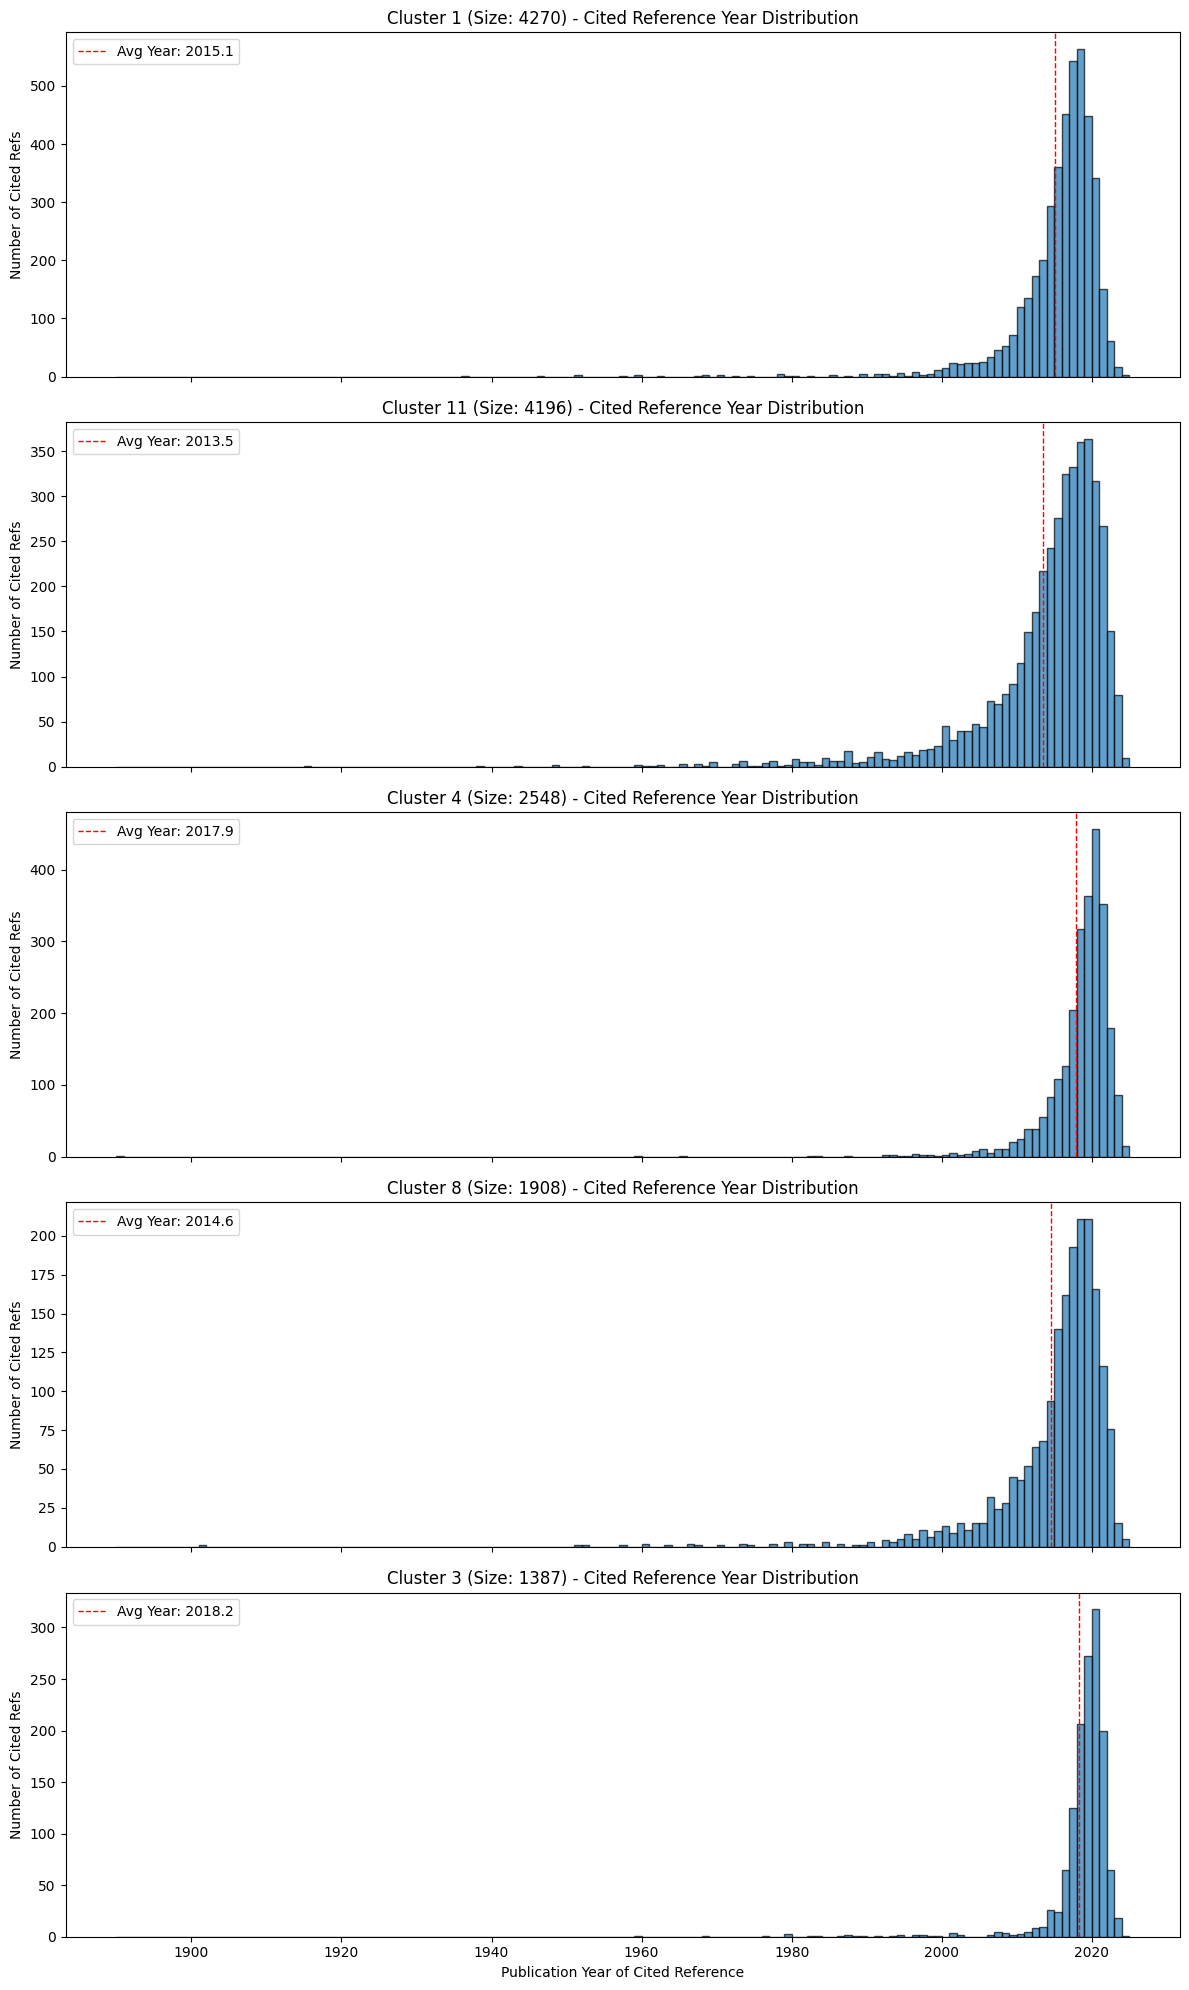

In [26]:
if G_lcc is not None and not cluster_summary_df.empty:
    print("\n--- Temporal Analysis of Cited References within Top Clusters ---")
    
    # Analyze a few top clusters for brevity
    num_clusters_for_temporal_plot = min(5, len(cluster_summary_df))
    
    if num_clusters_for_temporal_plot > 0:
        fig, axes = plt.subplots(num_clusters_for_temporal_plot, 1, figsize=(12, 4 * num_clusters_for_temporal_plot), sharex=True)
        if num_clusters_for_temporal_plot == 1:
            axes = [axes] # Make it iterable if only one subplot
            
        all_node_years = [int(data['year']) for node, data in G_lcc.nodes(data=True) if data.get('year', 'Unknown').isdigit()]
        if not all_node_years:
            print("No valid year data found in graph nodes for temporal analysis.")
        else:
            min_graph_year = min(all_node_years) if all_node_years else 1900
            max_graph_year = max(all_node_years) if all_node_years else 2025
            year_bins = np.arange(min_graph_year, max_graph_year + 2) # +2 for right edge of last bin

            for i in range(num_clusters_for_temporal_plot):
                cluster_id = cluster_summary_df.loc[i, 'Cluster ID']
                # Ensure partition is not empty and cluster_id is valid
                if partition and cluster_id in set(partition.values()):
                    nodes_in_comm = [node for node, comm in partition.items() if comm == cluster_id]
                else:
                    nodes_in_comm = [] # No nodes if partition is empty or id not found
                
                node_years_in_comm = []
                for node_id in nodes_in_comm:
                    if node_id in G_lcc.nodes: # Check if node exists in G_lcc
                        year_str = G_lcc.nodes[node_id].get('year', 'Unknown')
                        if year_str.isdigit():
                            node_years_in_comm.append(int(year_str))
                
                if node_years_in_comm:
                    ax = axes[i]
                    ax.hist(node_years_in_comm, bins=year_bins, edgecolor='black', alpha=0.7)
                    ax.set_title(f"Cluster {cluster_id} (Size: {len(nodes_in_comm)}) - Cited Reference Year Distribution")
                    ax.set_ylabel("Number of Cited Refs")
                    avg_year_comm = np.mean(node_years_in_comm)
                    ax.axvline(avg_year_comm, color='red', linestyle='dashed', linewidth=1, label=f'Avg Year: {avg_year_comm:.1f}')
                    ax.legend()
                else:
                    axes[i].set_title(f"Cluster {cluster_id} - No valid year data for nodes or cluster is empty")
            
            if num_clusters_for_temporal_plot > 0 and all_node_years: # Ensure axes were created
                 axes[-1].set_xlabel("Publication Year of Cited Reference")
                 plt.tight_layout()
                 plt.show()
            elif not all_node_years:
                 pass # Already printed message about no year data
            else: # num_clusters_for_temporal_plot is 0
                 print("No clusters to plot for temporal analysis.")
    else:
        print("No clusters large enough for temporal plot analysis.")

### 7. Visualization of Clustered Graph (LCC)


Visualizing the largest connected component with communities...


C:\Users\cdsn\AppData\Local\Temp\ipykernel_154124\519705453.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', max(valid_community_ids) + 1) # Or 'tab20', 'Set3'


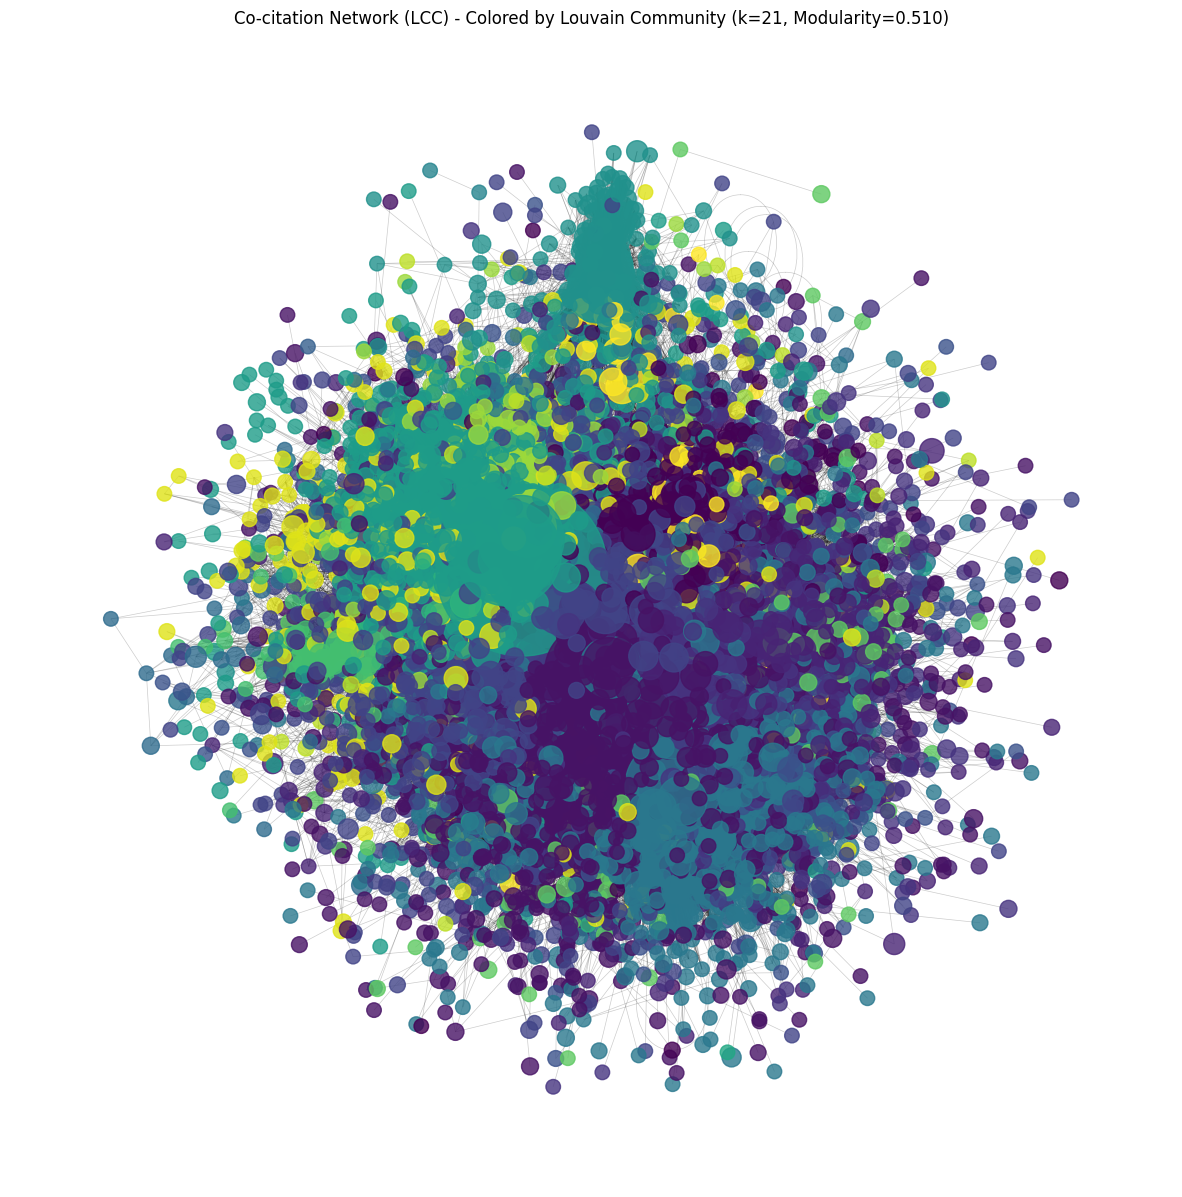

In [27]:
if G_lcc is not None and G_lcc.number_of_nodes() > 0 and num_communities > 0:
    print("\nVisualizing the largest connected component with communities...")
    plt.figure(figsize=(15, 15))
    
    # Use spring_layout or kamada_kawai_layout. Kamada-Kawai can be slow for large graphs.
    # For very large graphs, consider a simpler layout or visualizing subgraphs.
    if G_lcc.number_of_nodes() < 500: # Kamada-Kawai for smaller graphs
        pos = nx.kamada_kawai_layout(G_lcc, weight='weight')
    else: # Spring layout for larger graphs (can be adjusted)
        pos = nx.spring_layout(G_lcc, k=0.1, iterations=50, weight='weight', seed=42)
        
    # Node colors based on community
    # Ensure all nodes in G_lcc are in the partition map, or handle missing ones
    community_ids = [partition.get(node, -1) for node in G_lcc.nodes()] # Default to -1 if node not in partition
    valid_community_ids = [cid for cid in community_ids if cid != -1]
    
    if not valid_community_ids: # Check if any node got a valid community ID
        print("No valid community IDs found for nodes in LCC. Skipping visualization.")
    else:
        cmap = cm.get_cmap('viridis', max(valid_community_ids) + 1) # Or 'tab20', 'Set3'
        
        # Node sizes based on frequency ('freq' attribute)
        node_sizes = [G_lcc.nodes[node].get('freq', 1) * 20 + 10 for node in G_lcc.nodes()] # Scale for visibility
        
        nx.draw_networkx_nodes(G_lcc, pos, node_color=community_ids, cmap=cmap, node_size=node_sizes, alpha=0.8)
        nx.draw_networkx_edges(G_lcc, pos, alpha=0.2, width=0.5)
        
        # Optional: Add labels to very important nodes (e.g., top N by frequency)
        # sorted_nodes_for_labels = sorted(G_lcc.nodes(data=True), key=lambda x: x[1].get('freq', 0), reverse=True)
        # labels_to_draw = {node: data.get('label', '')[:20]+"..." for node, data in sorted_nodes_for_labels[:10]} # Label top 10
        # nx.draw_networkx_labels(G_lcc, pos, labels=labels_to_draw, font_size=8)
        
        plt.title(f"Co-citation Network (LCC) - Colored by Louvain Community (k={num_communities}, Modularity={modularity:.3f})")
        plt.axis('off')
        plt.show()
elif G_lcc is not None and G_lcc.number_of_edges() == 0:
    print("Skipping graph visualization as the graph (LCC) has no edges.")
else:
    print("Skipping graph visualization as graph is not suitable or no communities found.")
